### Downloading data from kaggle (kaggle api)

For this to work you need to:
- have kaggle account,
- create kaggle api token and put it in a right folder on your computer (credentials),
- enter competition and accept its rules.

[Kaggle API](https://www.kaggle.com/docs/api)

In [1]:
#!kaggle competitions list

In [2]:
#!kaggle competitions download -c house-prices-advanced-regression-techniques

### Importing and loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from pyod.models.knn import KNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Dependent variable

In [3]:
df_train['SalePrice'].corr(df_train['Id'])

-0.02191671944343111

Removing id variables (after checking there is no correlation)

In [4]:
test_id = df_test['Id']

In [5]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [6]:
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

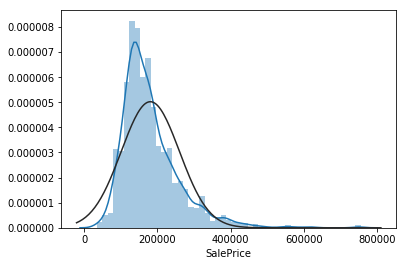

In [7]:
sns.distplot(df_train['SalePrice'], fit=norm)

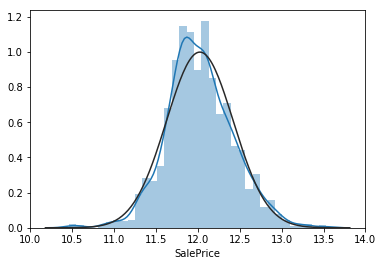

In [8]:
sns.distplot(np.log1p(df_train['SalePrice']), fit=norm)

Sale Prices have right skewed distribution, while for logarithms it seems quite normal. Since evaluation will be based on logarithm of sale prices, we should transform it.

In [9]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

### Missing data

In [10]:
missing_data = df_train.isnull().sum().sort_values(ascending=False)
columns = pd.DataFrame({'Missing data [%]': missing_data[missing_data>0]/df_train.shape[0]})
columns

,Missing data [%]
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageType,0.055479
GarageCond,0.055479
GarageFinish,0.055479
GarageQual,0.055479


Basically only a small amount of houses have features like:
- swimming pool,
- miscellaneous (other),
- alley access to property,
- fence,
- fireplace. <br><br>
I'm going to make binary variables of out them, since not only not many houses have these features, but also they have few classes on their own. Even though there is 99,5% houses have swimming pools, i think that variable may differentiate price.

In [11]:
binary = missing_data.index.tolist()[:5]

In [12]:
for feature in binary:
    name = '{}_bool'.format(feature)
    df_train[name] = np.where(df_train[feature].isna()==True, 'None', 'Has')
    df_test[name] = np.where(df_test[feature].isna()==True, 'None', 'Has')

In [13]:
df_train.drop(binary, axis=1, inplace=True)
df_test.drop(binary, axis=1, inplace=True)

Filling rest of missing data with mean/median (numeric/categorical).

In [14]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [15]:
df_train.fillna('Missing', inplace=True)
df_test.fillna('Missing', inplace=True)

### Skewness

Checking the distribution of left variables, mainly skewness.

In [16]:
skewed_variables = df_train.skew(numeric_only=True).abs().sort_values(ascending=False)
columns_2 = pd.DataFrame({'Skewness': skewed_variables[skewed_variables>3.0]})
columns_2

,Skewness
MiscVal,24.476794
PoolArea,14.828374
LotArea,12.207688
3SsnPorch,10.304342
LowQualFinSF,9.011341
KitchenAbvGr,4.488397
BsmtFinSF2,4.255261
ScreenPorch,4.122214
BsmtHalfBath,4.103403
EnclosedPorch,3.089872


In [17]:
df_train[columns_2.index] = np.log1p(df_train[columns_2.index])
df_test[columns_2.index] = np.log1p(df_test[columns_2.index])

#### Categorical data

I want to check categorical variables now. If variable has too many classes, it can be problematic for model to learn the dependency.

In [18]:
df_train.select_dtypes(include='object').nunique().sort_values(ascending=False)[:5]

Neighborhood    25
Exterior2nd     16
Exterior1st     15
Condition1       9
SaleType         9
dtype: int64

In [19]:
df_train['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

There is nothing we can do about without using external data. Seems ok :-)

### Differences between test and training sets

In [20]:
((df_train.mean()-df_test.mean())/df_train.mean()).abs().sort_values(ascending=False)[:10]

LowQualFinSF     0.455274
3SsnPorch        0.454911
PoolArea         0.201856
ScreenPorch      0.197512
EnclosedPorch    0.170302
BsmtHalfBath     0.135228
BsmtFinSF2       0.082237
2ndFlrSF         0.060591
Fireplaces       0.051865
OpenPorchSF      0.035440
dtype: float64

In [21]:
df_train['LowQualFinSF'].describe(), df_test['LowQualFinSF'].describe()

(count    1460.000000
 mean        0.099814
 std         0.747354
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         6.350886
 Name: LowQualFinSF, dtype: float64, count    1459.000000
 mean        0.054371
 std         0.557179
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         6.970730
 Name: LowQualFinSF, dtype: float64)

Dataset is pretty well balanced.

### Outliers

In [22]:
df_outliers = df_train.select_dtypes(include='number')

2,5% - arbitrary number

In [23]:
clf = KNN(contamination=0.025)

In [24]:
clf.fit(X=df_outliers.values)

KNN(algorithm='auto', contamination=0.025, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [25]:
scores_pred = clf.decision_function(df_outliers.values)*-1

In [26]:
outliers_pred = clf.predict(df_outliers.values)
outliers = pd.DataFrame(outliers_pred, columns=['outlier'])
outliers.shape, sum(outliers_pred), df_outliers.shape

((1460, 1), 30, (1460, 37))

In [27]:
df_train_clean = pd.concat([df_train, outliers], axis=1)

In [28]:
df_train_clean.query('outlier==0', inplace=True)
df_train_clean.drop('outlier', axis=1, inplace=True)

### Preparing dataset for models

In [29]:
def add_dummies(train, test, y_name):
    """
    train: DataFrame with training data
    test: DataFrame with test data
    y_name: string containing name of dependent variable
    """
    y = train[y_name]
    all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
    categorical = pd.get_dummies(all_data.select_dtypes(include='object'))
    numerical = all_data.drop(y_name, axis=1).select_dtypes(include='number')
    new_training = pd.concat([numerical, categorical], axis=1)[:len(train)]
    new_test = pd.concat([numerical, categorical], axis=1)[len(train):]
    return new_training, new_test, y

In [30]:
def my_rmse(actual, predictions):
    return sqrt(mean_squared_error(actual, predictions))

In [31]:
def cv_results(model, train, kfold=5):
    training_results = []
    val_results = []
    cv = KFold(n_splits=kfold, shuffle=True, random_state=123)
    for train, val in cv.split(train):
        model.fit(x.values[train], y.values[train])
        training_results.append(my_rmse(y.values[train], model.predict(x.values[train])))
        val_results.append(my_rmse(y.values[val], model.predict(x.values[val])))
    print('Validation result - RMSE:', np.mean(val_results))
    print('Training result - RMSE:', np.mean(training_results))

### Random forest

In [81]:
rf = RandomForestRegressor(max_depth=4, random_state=123, n_estimators=250, max_features='auto')

In [33]:
x, test_x, y = add_dummies(df_train, df_test, 'SalePrice')

In [34]:
x.shape, test_x.shape, y.shape

((1460, 298), (1459, 298), (1460,))

In [35]:
cv_results(rf, x)

Validation result - RMSE: 0.17602108089010207
Training result - RMSE: 0.1510666094763671


### Random forest - clean data (PyOD)

In [36]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [37]:
x.shape, test_x.shape, y.shape

((1430, 297), (1459, 297), (1430,))

In [38]:
cv_results(rf, x)

Validation result - RMSE: 0.16819632236936657
Training result - RMSE: 0.14746417147696583


### xgboost

In [111]:
x, test_x, y = add_dummies(df_train, df_test, 'SalePrice')

In [112]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.05, subsample=0.8, 
                          max_depth=4, alpha=10, n_estimators=250, num_boost_round=50, gamma=0.05,
                         reg_alpha=0.5, reg_lambda=0.9, early_stopping_rounds=20, seed=123)

In [113]:
cv_results(xg_reg, x)

Validation result - RMSE: 0.12798672837873662
Training result - RMSE: 0.09012879228110597


Clean data

In [109]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [110]:
cv_results(xg_reg, x)

Validation result - RMSE: 0.12149891728136397
Training result - RMSE: 0.08920169123320928


Faster way. xgboost supports data structure called Dmatrix, which is more efficient. Package also provides their own cross validation.

In [44]:
data_dmatrix = xgb.DMatrix(data=x.values,label=y.values)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.05,
                'max_depth': 4, 'alpha': 10}

cv_results_xgb = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

print(cv_results_xgb.tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.945553        0.001662        0.946875        0.00872


### lightgbm

In [45]:
lgb_reg = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=250)

In [46]:
x, test_x, y = add_dummies(df_train, df_test, 'SalePrice')

In [47]:
cv_results(lgb_reg, x)

Validation result - RMSE: 0.12943463881637224
Training result - RMSE: 0.09468997991311391


Clean data

In [48]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [49]:
cv_results(lgb_reg, x)

Validation result - RMSE: 0.12128947020720178
Training result - RMSE: 0.08854011694186266


### Lasso regression

In [50]:
lasso_reg = Lasso(alpha=0.0005, random_state=123)

In [51]:
x, test_x, y = add_dummies(df_train, df_test, 'SalePrice')

In [52]:
cv_results(lasso_reg, x)

Validation result - RMSE: 0.1362764067047247
Training result - RMSE: 0.10286185888514614


Clean data

In [53]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [54]:
cv_results(lasso_reg, x)

Validation result - RMSE: 0.11053913261894407
Training result - RMSE: 0.0971726692653439


### ElasticNet

In [55]:
enet_reg = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=123)

In [56]:
x, test_x, y = add_dummies(df_train, df_test, 'SalePrice')

In [57]:
cv_results(enet_reg, x)

Validation result - RMSE: 0.13630079563284966
Training result - RMSE: 0.10232528108640615


Clean data

In [58]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [59]:
cv_results(enet_reg, x)

Validation result - RMSE: 0.110451389925638
Training result - RMSE: 0.09648594027975946


## Stacking models

Random forest is clearly worse than the rest of the models, so i will be stacking the other 4.

In [94]:
x, test_x, y = add_dummies(df_train, df_test, 'SalePrice')

In [95]:
models = [xg_reg, lgb_reg, lasso_reg, enet_reg]
results = np.zeros(len(test_x))

In [96]:
for model in models:
    model.fit(x.values, y.values)
    results = results + model.predict(test_x.values)

### Kaggle submission

In [97]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = np.exp(results/len(models))
sub.to_csv('submission.csv', index=False)

In [99]:
#!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Ensemble models"

Your submission scored 0.12105.

### Clean data

In [88]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [89]:
models = [xg_reg, lgb_reg, lasso_reg, enet_reg]
results = np.zeros(len(test_x))

In [90]:
for model in models:
    model.fit(x.values, y.values)
    results = results + model.predict(test_x.values)

### Kaggle submission

In [91]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = np.exp(results/len(models))
sub.to_csv('submission.csv', index=False)

In [93]:
#!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Ensemble models clean data"

Top 20%, <br>
Your submission scored 0.11893.

Ensemble of pretty much vanilla models gave us a top 20% result of a long on-going competition.

### Tuning hyperparameters of each model

todo/pca

## Learning TensorFlow 2.0

[Tutorial](https://www.tensorflow.org/tutorials/keras/basic_regression)

Normalizing data

In [364]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [365]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
test_x = scaler.transform(test_x)

Just a random split, not cv, because of time.

In [366]:
train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.25, random_state=123)

In [367]:
list(map(len, [train_data, test_data, train_labels, test_labels]))

[1072, 358, 1072, 358]

In [368]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[train_data.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [369]:
tf_model = build_model()

In [370]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

In [371]:
tf_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 32)                9536      
_________________________________________________________________
dense_71 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_72 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 17        
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
_________________________________________________________________


In [372]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [373]:
EPOCHS = 1000

In [374]:
history = tf_model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), early_stop])


....................................................................................................
..................................................................................

In [375]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
177,0.042606,0.042606,2.011924,2.011924,177
178,0.051875,0.051875,1.992179,1.992179,178
179,0.047283,0.047283,2.087370,2.087370,179
180,0.048058,0.048058,1.954111,1.954111,180
181,0.047067,0.047067,2.053062,2.053061,181


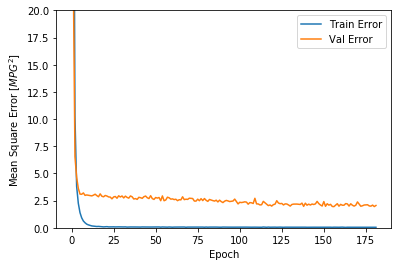

In [376]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [377]:
print(np.sqrt(tf_model.evaluate(test_data, test_labels, verbose=0))[0])

1.3474126410765075


# TODO: better tensorflow